In [56]:
import numpy as np
import numpy
import cv2
import time
from contextlib import contextmanager

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import widgets

import os
import sys
module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.insert(0, '../')

from src.img_utils import (capture_screenshot, 
                           extract_object, 
                           extract_all_objects,
                           extract_edges)
from src.key_mouse_utils import (move_to,
                                 click,
                                 scroll_up,
                                 scroll_down,
                                 drag,
                                 write,
                                 enter, hit_key,
                                 mouse_up, mouse_down)

In [2]:
@contextmanager
def time_this():
    start = time.time()
    yield
    print(f"Time elapsed: {time.time()-start:.4f}")

In [3]:
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    global bounding_boxes, I
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    x1, y1, x2, y2 = [round(x) for x in [x1, y1, x2, y2]]
    bounding_boxes.append([(x1, y1),(x2, y2)])
    I = capture_screenshot()
    plt.imshow(I)
    plt.connect('key_press_event', toggle_selector)
    plt.show()
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))
    
def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)

In [4]:
# click(234, 28) #open new tab
# click(206, 17) #close tab
# time.sleep(1)

# click(473, 49)
# write("https://espritgames.com/wartime/go/")
# enter()
# time.sleep(10)z

# drag(1020, 350, 1020, 380)
# click(477, 380)
# drag(1020, 350, 1020, 380)
# click(477, 380)
# time.sleep(10)

# click(657, 149)

# click(936, 241)
# click(583, 660)

# click(486, 489)
# write(credentials["email"])
# click(436, 537)
# write(credentials["password"])

# click(489, 618)

# click(727, 257)
# click(530, 627)
# scroll_down()

In [5]:
# click(867, 55)
# move_to(867, 55)
# write("http://www.tptp.org/TPTP/Distribution/TPTP-v7.4.0.tgz")
# enter()
# time.sleep(10)
# for i in range(10):
#     click(612, 580)
#     time.sleep(2)

In [ ]:
%matplotlib widget
f, ax = plt.subplots(figsize=(8,7))
bounding_boxes = []
toggle_selector.RS = widgets.RectangleSelector(ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)

I = capture_screenshot()
# I = plt.imread()

plt.imshow(I)
plt.connect('key_press_event', toggle_selector)
plt.show()

In [7]:
bounding_box = bounding_boxes[-1]
bounding_box

[(3, 6), (218, 28)]

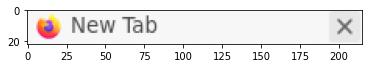

In [8]:
%matplotlib inline
template = I[bounding_box[0][1]:bounding_box[1][1], bounding_box[0][0]:bounding_box[1][0], :]
# fig = plt.figure(frameon=False, facecolor='white')
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
plt.imshow(template)
# plt.imsave('../templates/wut.png', template)
plt.show()

In [9]:
name = "confirm_blue_button"
# plt.imsave(f'../templates/{name}.png', template)

In [15]:
%matplotlib widget

with time_this():
    I_copy = I.copy()
#     bounding_boxes = extract_all_objects(template, I[I.shape[0]//2:,:,:])
#     for top_left, bottom_right in bounding_boxes:
#         cv2.rectangle(I_copy, top_left, bottom_right, 255, 2)
    bounding_box = extract_object(template, I)
    top_left, bottom_right = bounding_box
    cv2.rectangle(I_copy, top_left, bottom_right, 255, 2)
    plt.imshow(I_copy)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time elapsed: 0.1153


In [19]:
print(extract_edges(I).shape, np.min(extract_edges(I)), np.max(extract_edges(I)), np.median(extract_edges(I)))
plt.imshow(extract_edges(I))

(768, 1024) 0 255 0.0


In [52]:
%matplotlib widget
# Load image, create mask, grayscale, and Otsu's threshold
image = np.uint8(I.copy()*255)
mask = np.zeros(image.shape, dtype=np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Perform morph operations
open_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, open_kernel, iterations=1)
close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, close_kernel, iterations=3)

# Find horizontal sections and draw rectangle on mask 
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,3))
detect_horizontal = cv2.morphologyEx(close, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255,255,255), -1)
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255,255,255), 2)

# Find vertical sections and draw rectangle on mask 
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,25))
detect_vertical = cv2.morphologyEx(close, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255,255,255), -1)
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255,255,255), 2)

# Color mask onto original image
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
image[mask==255] = [0,0,0]

plt.imshow(opening)
plt.show()
# plt.imshow(close)
# plt.show()
# plt.imshow(image)
# plt.show()
plt.imshow(thresh)
plt.show()
# plt.imshow(mask)
# plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [70]:
%matplotlib widget
img = np.uint8(I * 255)

# Split out each channel
blue, green, red = cv2.split(img)

def medianCanny(img, thresh1, thresh2):
    median = numpy.median(img)
    img = cv2.Canny(img, int(thresh1 * median), int(thresh2 * median))
    return img

# Run canny edge detection on each channel
blue_edges = medianCanny(blue, 0.2, 0.3)
green_edges = medianCanny(green, 0.2, 0.3)
red_edges = medianCanny(red, 0.2, 0.3)

# Join edges back into image
edges = blue_edges | green_edges | red_edges

# Find the contours
_, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

hierarchy = hierarchy[0] # get the actual inner list of hierarchy descriptions

# For each contour, find the bounding rectangle and draw it
for component in zip(contours, hierarchy):
    currentContour = component[0]
    currentHierarchy = component[1]
    x,y,w,h = cv2.boundingRect(currentContour)
    if w < 10 or h < 10:
        continue
    if currentHierarchy[2] < 0:
        # these are the innermost child components
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)
    elif currentHierarchy[3] < 0:
        # these are the outermost parent components
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)

# Finally show the image
plt.imshow(img)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [65]:
type(img)

NoneType